In [1]:
import scipy
import numpy as np
from sympy.utilities.iterables import multiset_partitions, partitions
from itertools import permutations
# plot the bn values
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax.numpy as jnp
import jax
import math
from tqdm import tqdm

To bound the error, we need to be able to transform between the $y_k^{(j)}$ and the $x_{k,j}$ coefficients. We will do so using symbolic calculus.

In [2]:
cs = {} # It will be indexed by (s, m)
cs_y = {} # It will be indexed by (s, m)
cs[(2,2)] = [[1/2, 1/6], [1/2, 1/6]]
cs[(2,3)] = [[0, 1/12], [1, 0], [0, 1/12]]
cs[(3,5)] = [[0.2, 0.08734395950888931101, 0.03734395950888931101], 
        [0.34815492558797391479, 0.053438272547684150, 0.00584269157837031012],
        [abs(1-2*(0.2+0.34815492558797391479)), 0, abs(1/12-2*(0.03734395950888931101 + 0.00584269157837031012))],
        [0.34815492558797391479, 0.053438272547684150, 0.00584269157837031012],
        [0.2, 0.08734395950888931101, 0.03734395950888931101]]
cs[(3,6)] = [[0.208, 0.09023186422416794596, 0.03823186422416794596], 
        [0.312, 0.04467385661651479788, 0.00439421553992544024],
        [abs(1/2-(0.208 + 0.09023186422416794596)), 0.01407960659498524468, abs(1/24-(0.03823186422416794596+0.00439421553992544024))],
        [abs(1/2-(0.208 + 0.09023186422416794596)), 0.01407960659498524468, abs(1/24-(0.03823186422416794596+0.00439421553992544024))],
        [0.312, 0.04467385661651479788, 0.00439421553992544024],
        [0.208, 0.09023186422416794596, 0.03823186422416794596]]
cs_y[(4,11)] = [
        [0.169715531043933180094151, 0.152866146944615909929839, 0.119167378745981369601216, 0.068619226448029559107538],
        [0.379420807516005431504230, 0.148839980923180990943008, 0.115880829186628075021088, 0.188555246668412628269760],
        [0.469459306644050573017994, 0.379844237839363505173921, 0.022898814729462898505141, 0.571855043580130805495594],
        [0.448225927391070886302766, 0.362889857410989942809900, 0.022565582830528472333301, 0.544507517141613383517695],
        [0.293924473106317605373923, 0.026255628265819381983204, 0.096761509131620390100068, 0.000018330145571671744069],
        [0.447109510586798614120629, 0, 0.200762581179816221704073, 0],
        [0.293924473106317605373923, 0.026255628265819381983204, 0.096761509131620390100068, 0.000018330145571671744069],
        [0.448225927391070886302766, 0.362889857410989942809900, 0.022565582830528472333301, 0.544507517141613383517695],
        [0.469459306644050573017994, 0.379844237839363505173921, 0.022898814729462898505141, 0.571855043580130805495594],
        [0.379420807516005431504230, 0.148839980923180990943008, 0.115880829186628075021088, 0.188555246668412628269760],
        [0.169715531043933180094151, 0.152866146944615909929839, 0.119167378745981369601216, 0.068619226448029559107538]
        ]

In [3]:
from sympy.matrices import Matrix

def generate_T(order):
    T = Matrix(order, order, lambda i,j: (1-(-1)**(i+j+1))/((i+j+1)*2**(i+j+1)))
    return T

T = generate_T(2)
R = T.inv()
T, R

# Create a function that, given a vector of size n, multiplies it by T with appropriate size
def generate_x(n, y):
    r'''
    n: size of the vector
    x: vector to be multiplied by T

    Returns T@x
    '''
    assert(len(y) == n)
    T = generate_T(n)
    return T@y

def generate_y(n, x):
    r'''
    n: size of the vector
    y: vector to be multiplied by R

    Returns R@y
    '''
    assert(len(x) == n)
    R = generate_T(n).inv()
    return R@x

In [4]:
cs[(4,11)] = [list(generate_x(4, np.array(y))) for y in cs_y[(4,11)]]

cs_y[(2,2)] = [list(generate_y(2, np.array(x))) for x in cs[(2,2)]]
cs_y[(2,3)] = [list(generate_y(2, np.array(x))) for x in cs[(2,3)]]
cs_y[(3,5)] = [list(generate_y(3, np.array(x))) for x in cs[(3,5)]]
cs_y[(3,6)] = [list(generate_y(3, np.array(x))) for x in cs[(3,6)]]

In [5]:
cs[(4,11)]

[[0.179646145939432,
  0.0135965859093184,
  0.0156325531546525,
  0.00206399475298634],
 [0.389077543281558,
  0.0147602723269536,
  0.0330669109911666,
  0.00228138200856747],
 [0.471367541204839,
  0.0388018745313653,
  0.0394078440711225,
  0.00602451512384055],
 [0.450106392626948,
  0.0370471654151860,
  0.0376342304013042,
  0.00575154178268562],
 [0.301987932200619,
  0.00218819814897126,
  0.0257032249563384,
  0.000328236268826251],
 [0.463839725685117, 0, 0.0397686581469809, 0],
 [0.301987932200619,
  0.00218819814897126,
  0.0257032249563384,
  0.000328236268826251],
 [0.450106392626948,
  0.0370471654151860,
  0.0376342304013042,
  0.00575154178268562],
 [0.471367541204839,
  0.0388018745313653,
  0.0394078440711225,
  0.00602451512384055],
 [0.389077543281558,
  0.0147602723269536,
  0.0330669109911666,
  0.00228138200856747],
 [0.179646145939432,
  0.0135965859093184,
  0.0156325531546525,
  0.00206399475298634]]

# Computing the norm of $\|\Psi^{[2s]}_{m,p}\|$

In [6]:
factorial = {}
for i in range(100):
    factorial[i] = np.longdouble(math.factorial(i))

We define the parameters we are interested in:

In [7]:
s = 3
maxp = 30
m = 5
h = 1/(4*m)

We need two key functions `efficient_number_compositions` and `efficient_weak_compositions`

In [8]:
def efficient_number_compositions(p, s):
    r"""
    p: integers up to which compositions add up
    s: maximum value of each term in the composition

    Computes a dictionary where the key is the length of the composition,
    and the value is the number of compositions of that length.
    """
    pts = partitions(p, k=s)
    
    comps = {}
    for part in pts:
        len_ = np.sum(list(part.values()))

        num_comps = factorial[len_]
        for n in part.values():
            num_comps /= factorial[n]

        if len_ in comps.keys():
            comps[len_] += num_comps
        else:
            comps[len_] = num_comps

    return comps

In [9]:
def partition_to_list(part):
    l = []
    for k, v in part.items():
        l += [k]*v
    return l


def add_term(m, mean_cs, part):
    part_ = partition_to_list(part)
    part_ = part_ + [0]*(m-len(part_))
    perms = permutations(part_)
                
    add_term = np.longdouble(0)
    for per in perms:
        add_term += np.prod([mean_cs[i]**per[i]/factorial[per[i]] for i in range(len(per))])
    return add_term

def efficient_weak_compositions(maxw, list_m, list_cs, use_max = True):
    r"""
    Computes sum{k_1...k_m\in weak_compositions} c^{k_1}/k_1!...c^{k_m}/k_m!) for all weak compositions of length m.
    Depending on the value of `use_max`, it uses either the maximum value of c for all at once (faster) or the specific values of c,
    (more accurate).

    maxw: maximum value of the sum of the weak composition
    list_m: list of the possible values of m.
    list_cs: list of the possible values of cs.
    use_max: if True, use the maximum value of cs instead of the specific values of cs. Faster but less accurate.
    """

    weak_comps = {}
    for m, cs in zip(list_m, list_cs):

        vector_add_term = np.vectorize(lambda part: add_term(m, mean_cs, part))

        max_cs = np.max(cs)
        mean_cs = np.mean(cs, axis = 1)

        weak_comps[m] = {}
        for normw in range(maxw+1):
            
            suma = np.longdouble(0)

            pts = partitions(normw, m=m)

            if use_max:
                for part in pts:
                    len_ = np.sum(list(part.values()))

                    num_comps = factorial[m]/factorial[m-len_] * max_cs**len_
                    for n in part.values():
                        num_comps /= factorial[n]

                    denominator = np.longdouble(1)
                    for i in part.keys():
                        denominator = denominator*factorial[i]

                    suma = suma + num_comps/denominator

            else:
                add = vector_add_term(list(pts))
                suma += np.sum(add)

            weak_comps[m][normw] = suma

    return weak_comps


maxw = 20
weak_comps = efficient_weak_compositions(maxw, list_m = [m], list_cs = [cs[(s,m)]], use_max=False)
for normw in range(maxw+1):
    print(f'm={m}, w={normw}, result={weak_comps[m][normw]}')

m=5, w=0, result=120.0
m=5, w=1, result=12.508779499845966
m=5, w=2, result=1.9983732208000755
m=5, w=3, result=0.22504924447088248
m=5, w=4, result=0.02598250970126983
m=5, w=5, result=0.0024216242281356083
m=5, w=6, result=0.00016313929377626265
m=5, w=7, result=1.0445053959739564e-05
m=5, w=8, result=6.360249748589366e-07
m=5, w=9, result=3.272201172014055e-08
m=5, w=10, result=1.6158000937798141e-09
m=5, w=11, result=6.872322329074741e-11
m=5, w=12, result=2.8501853018568223e-12
m=5, w=13, result=1.0678481357272069e-13
m=5, w=14, result=3.779052639191287e-15
m=5, w=15, result=1.2465305519052182e-16
m=5, w=16, result=3.916442364307838e-18
m=5, w=17, result=1.1484258358005157e-19
m=5, w=18, result=3.199132884938854e-21
m=5, w=19, result=8.443656701299134e-23
m=5, w=20, result=2.1516947390275817e-24


Final calculation

In [10]:
def summatory_compositions(h, maxp, s, list_m, list_cs, use_max = True): #todo: better choose between maximum and actual value
    r"""
    maxp: maximum order p of the summatory
    s: 2s is the order of the Commutator Free Magnus operator
    maxc: maximum value of the norm of |x_{i,j}a_j|
    cs: list of values |x_{i,j}a_j| for each i,j

    Note: you should choose one of cs and maxc, not both.
    """

    weak_comps = efficient_weak_compositions(maxp, list_m, list_cs, use_max)

    suma = {}
    for p in range(1, maxp+1):
        num_comps = efficient_number_compositions(p, s)

        suma[p] = np.longdouble(0)
        for len_comp, nc in num_comps.items():
            suma[p] += nc*weak_comps[m][len_comp] * h**p

    return suma

sum_compositions = summatory_compositions(h, maxp, s, [m], [cs[(s,m)]], use_max = True)

#accumulate sum_compositions
acc_sum_compositions = {}
acc_sum_compositions[0] = 0
for i in range(1, maxp+1):
    acc_sum_compositions[i] = acc_sum_compositions[i-1] + sum_compositions[i]


for i in range(1, maxp+1):
    print(f'{i}: {sum_compositions[i]}, {acc_sum_compositions[i]}')

1: 0.08703873139699347, 0.08703873139699347
2: 0.009558201160053703, 0.09659693255704718
3: 0.0009787548700926263, 0.0975756874271398
4: 8.630859781959907e-05, 0.0976619960249594
5: 7.556410239295036e-06, 0.09766955243519869
6: 6.413007132720286e-07, 0.09767019373591196
7: 5.21406942001763e-08, 0.09767024587660617
8: 4.141176091661513e-09, 0.09767025001778226
9: 3.2045407312889726e-10, 0.09767025033823634
10: 2.4318208473478705e-11, 0.09767025036255456
11: 1.8155396782699394e-12, 0.09767025036437009
12: 1.3369537784265144e-13, 0.09767025036450379
13: 9.740230435300974e-15, 0.09767025036451353
14: 7.038638596730466e-16, 0.09767025036451424
15: 5.0464542234809233e-17, 0.0976702503645143
16: 3.587815632517645e-18, 0.0976702503645143
17: 2.528712955093948e-19, 0.0976702503645143
18: 1.7680571474251283e-20, 0.0976702503645143
19: 1.2277620102284523e-21, 0.0976702503645143
20: 8.47432929480125e-23, 0.0976702503645143
21: 5.815519972158196e-24, 0.0976702503645143
22: 3.9690101613678474e-25, 0

Accumulating the error over all orders $p>2s+1$

In [11]:
def acc_from(n, sum_compositions, maxp):
    
    acc_sum_compositions = {}
    acc_sum_compositions[n-1] = 0
    for i in range(n, maxp+1):
        acc_sum_compositions[i] = acc_sum_compositions[i-1] + sum_compositions[i]

    return acc_sum_compositions

acc_sum_compositions = acc_from(2*s+1, sum_compositions, maxp)
for i in range(2*s+1, maxp+1):
    print(f'{i}: {acc_sum_compositions[i]}')

7: 5.21406942001763e-08
8: 5.628187029183781e-08
9: 5.660232436496671e-08
10: 5.662664257344019e-08
11: 5.6628458113118454e-08
12: 5.66285918084963e-08
13: 5.6628601548726736e-08
14: 5.6628602252590594e-08
15: 5.6628602303055136e-08
16: 5.662860230664295e-08
17: 5.662860230689582e-08
18: 5.6628602306913504e-08
19: 5.6628602306914735e-08
20: 5.662860230691482e-08
21: 5.662860230691483e-08
22: 5.662860230691483e-08
23: 5.662860230691483e-08
24: 5.662860230691483e-08
25: 5.662860230691483e-08
26: 5.662860230691483e-08
27: 5.662860230691483e-08
28: 5.662860230691483e-08
29: 5.662860230691483e-08
30: 5.662860230691483e-08


We can compare using both modes in, for $s = 3$ and $m = 5$ and $m = 6:

In [12]:
sum_compositions = summatory_compositions(h, maxp, s, [m], [cs[(s,m)]], use_max = True)

acc_sum_compositions = acc_from(2*s+1, sum_compositions, maxp)
for i in range(2*s+1, maxp+1):
    print(f'{i}: {acc_sum_compositions[i]}')

7: 5.21406942001763e-08
8: 5.628187029183781e-08
9: 5.660232436496671e-08
10: 5.662664257344019e-08
11: 5.6628458113118454e-08
12: 5.66285918084963e-08
13: 5.6628601548726736e-08
14: 5.6628602252590594e-08
15: 5.6628602303055136e-08
16: 5.662860230664295e-08
17: 5.662860230689582e-08
18: 5.6628602306913504e-08
19: 5.6628602306914735e-08
20: 5.662860230691482e-08
21: 5.662860230691483e-08
22: 5.662860230691483e-08
23: 5.662860230691483e-08
24: 5.662860230691483e-08
25: 5.662860230691483e-08
26: 5.662860230691483e-08
27: 5.662860230691483e-08
28: 5.662860230691483e-08
29: 5.662860230691483e-08
30: 5.662860230691483e-08


In [13]:
sum_compositions = summatory_compositions(h, maxp, s, [m], [cs[(s,m)]], use_max = False)

acc_sum_compositions = acc_from(2*s+1, sum_compositions, maxp)
for i in range(2*s+1, maxp+1):
    print(f'{i}: {acc_sum_compositions[i]}')

7: 1.4088509892845816e-09
8: 1.4574823885483643e-09
9: 1.4589632421364088e-09
10: 1.459002191153133e-09
11: 1.4590033396543893e-09
12: 1.459003370071049e-09
13: 1.459003370814985e-09
14: 1.4590033708341649e-09
15: 1.459003370834623e-09
16: 1.4590033708346337e-09
17: 1.4590033708346339e-09
18: 1.4590033708346339e-09
19: 1.4590033708346339e-09
20: 1.4590033708346339e-09
21: 1.4590033708346339e-09
22: 1.4590033708346339e-09
23: 1.4590033708346339e-09
24: 1.4590033708346339e-09
25: 1.4590033708346339e-09
26: 1.4590033708346339e-09
27: 1.4590033708346339e-09
28: 1.4590033708346339e-09
29: 1.4590033708346339e-09
30: 1.4590033708346339e-09


Let us plot the different errors for every formula and every $m$, for different values of $h$.

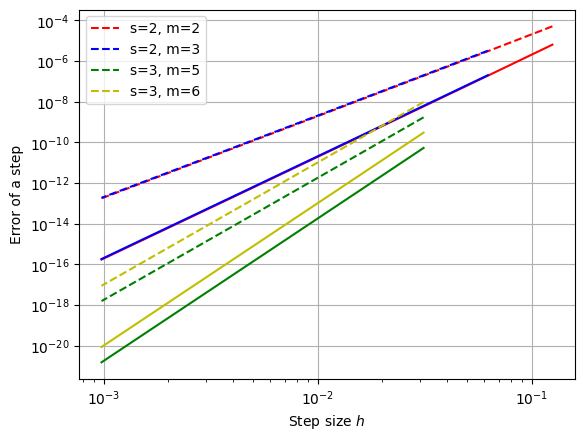

<Figure size 640x480 with 0 Axes>

In [14]:
hs = [1/(2) * 1/2**i for i in range(1,10)]
maxp = 20
tight = True
for (s, m, color) in zip([2, 2, 3, 3], [2, 3, 5, 6], ['r', 'b', 'g', 'y']):
    plot_hs = []
    step_error = []
    error = []
    for h in hs:
        if h <= 1/(4*m):
            plot_hs.append(h)
        else:
            continue
        if s < 4:
            sum_compositions = summatory_compositions(h, maxp, s, [m], [cs[(s,m)]], use_max= not tight)
        else:
            sum_compositions = summatory_compositions(h, maxp, s, [m], [cs[(s,m)]], use_max=True)

        acc_sum_compositions = acc_from(2*s+1, sum_compositions, maxp)
        error.append(acc_sum_compositions[maxp])
        step_error.append(acc_sum_compositions[maxp]/h)

    plt.plot(plot_hs, error, color = color, label = f's={s}, m={m}')
    # Discontinous plot for the step error
    plt.plot(plot_hs, step_error, color = color, linestyle='dashed', label = f's={s}, m={m}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error of a step')
plt.xlabel(r'Step size $h$')
plt.grid()
plt.show()
plt.savefig(f'error_bounds_tight={tight}.pdf')


# Error bound for $\|\exp(\Omega_{2s,2s})_{p}\|$

In [15]:
# Compute all the permutations of a partition
def partition_to_list(part):
    l = []
    for k, v in part.items():
        l += [k]*v
    return l

In [16]:
def efficient_bound(h, p, maxc):
    r"""
    Computes a bound for the error of the Magnus expansion of order p.

    p: order of the Magnus expansion
    s: 2s is the order of the Commutator Free Magnus operator
    z: order of the exponential of the Magnus expansion.
    c: maximum value of the norm of |a_j|
    """
    bound = np.longdouble(0)

    # We first generate all partitions of p into z parts of size up to 2s
    pts = list(partitions(p))

    # For each possible partition,
    for part in pts:
        large_comb_size = np.sum(list(part.values()))
        num_combs_large = factorial[large_comb_size]/np.prod([factorial[v] for v in part.values()])


        # We further generate more partitions of each part into up to 2s parts
        product = np.longdouble(1)
        for k in part.keys(): # Iterating over the dictionary of a big partition
            suma = np.longdouble(0)
            js = partitions(k)
            for j in js: # Here we get a dictionary of small partitions
                size = np.sum(list(j.values()))
                num_small_combs = factorial[size]/np.prod([factorial[jv] for jv in j.values()])
                #print('j:', j, 'size:', size, 'num_small_combs:', num_small_combs)
                term = maxc**size / size 
                term = term / np.prod([jk**jv for jk, jv in j.items()])
                suma = suma + term * num_small_combs

            #print('sum', suma/2**(k-1))

            product = product * suma

        bound += num_combs_large/factorial[large_comb_size] * product

    assert(bound/2**(p) <= 1)

    return bound * (h/2)**p

h = 1/10
s = 2
maxc = 1
for p in range(0, 30):
    print(p, efficient_bound(h, p, maxc))

0 1.0
1 0.05
2 0.0037500000000000007
3 0.0002916666666666667
4 2.291666666666667e-05
5 1.8072916666666673e-06
6 1.412326388888889e-07
7 1.1207527281746036e-08
8 8.734314933655759e-10
9 6.954548615416942e-11
10 5.417337380599305e-12
11 4.3096478835156846e-13
12 3.367460402129433e-14
13 2.6766287668461472e-15
14 2.0919064253234375e-16
15 1.6650291607462634e-17
16 1.302630932533608e-18
17 1.0346255348404387e-19
18 8.122552908992191e-21
19 6.444424426164205e-22
20 5.0587602136661414e-23
21 4.017628181602502e-24
22 3.1566284993516367e-25
23 2.5030963487573108e-26
24 1.970560540907625e-27
25 1.5616839414672155e-28
26 1.2294767520755277e-29
27 9.749359832479602e-31
28 7.677901382336094e-32
29 6.082948220272143e-33


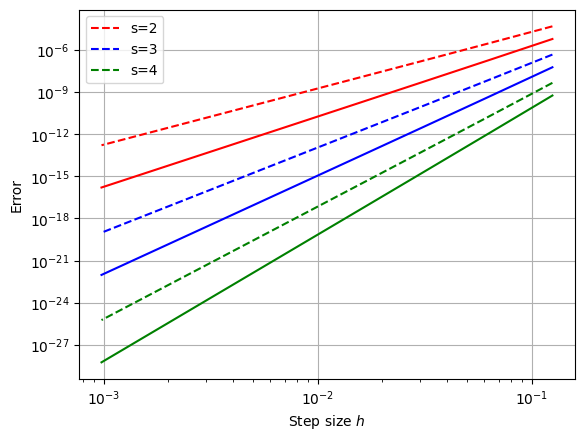

In [17]:
# Compute the accumulated bound for different values of h and s
hs = [1/(2) * 1/2**i for i in range(1,10)]
maxp = 20
m = 2

for (s, color) in zip([2, 3, 4], ['r', 'b', 'g']):
    plot_hs = []
    step_error = []
    error = []
    for h in hs:
        if h <= 1/(4*m):
            plot_hs.append(h)
        else:
            continue

        bound = []
        for p in range(0, maxp+1):
            bound.append(efficient_bound(h, p, 1))
        
        acc_bound = {}
        acc_bound[2*s] = 0
        for i in range(2*s+1, len(bound)):
            acc_bound[i] = acc_bound[i-1] + bound[i]
        error.append(acc_bound[maxp])
        step_error.append(acc_bound[maxp]/h)

    plt.plot(plot_hs, error, color = color, label = f's={s}')
    # Discontinous plot for the step error
    plt.plot(plot_hs, step_error, color = color, linestyle='dashed', label = f's={s}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel(r'Step size $h$')
plt.grid()
plt.savefig(f'error_bounds_exp_taylor.pdf')
plt.show()

In [18]:
step_error

[4.5933457983206765e-09,
 1.7021856827422222e-11,
 6.483018689662595e-14,
 2.501202686556382e-16,
 9.710477171656012e-19,
 3.781575774584099e-21,
 1.4749269974884385e-23,
 5.757047276325362e-26]

# Other error contributions

First, the truncation of the Taylor expansion of the Magnus operator in terms of the generators

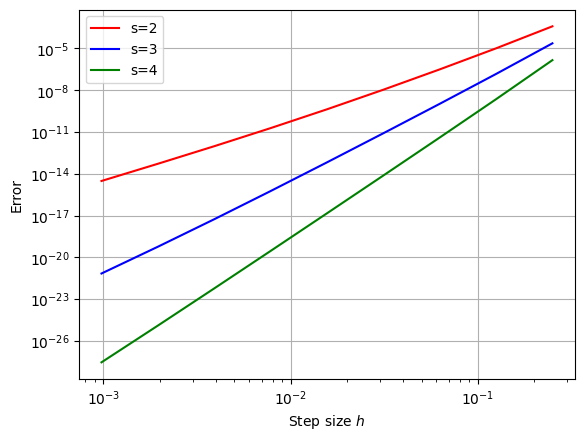

In [26]:
c = 1
def error_Taylor_truncation(h, s, c):
    r"""
    Computes the error of the Taylor truncation of the Magnus expansion of order 2s+1.
    h: step size
    s: order of the Magnus expansion
    c: norm of the Hamiltonian and its derivatives
    """
    
    return h**(2*s+1)*(
        (c**(2*s+1)/((2*s+1)*2**(2*s+2))) + c*h/4 - (h**(2*s+1)*c**(2*s+1))/(2**(2*s+1))
    )*(1/(1-h))*(1/(1-(h/2)))

# Plot the error of the Taylor truncation for different values of s and h
hs = [1/(2) * 1/2**i for i in range(1,10)]

for (s, color) in zip([2, 3, 4], ['r', 'b', 'g']):
    plot_hs = []
    error = []
    for h in hs:
        plot_hs.append(h)
        error.append(error_Taylor_truncation(h, s, c)/h)

    plt.plot(plot_hs, error, color = color, label = f's={s}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel(r'Step size $h$')
plt.grid()

Error of the exponential of the Magnus operator. See however the section above for a more accurate error bound.

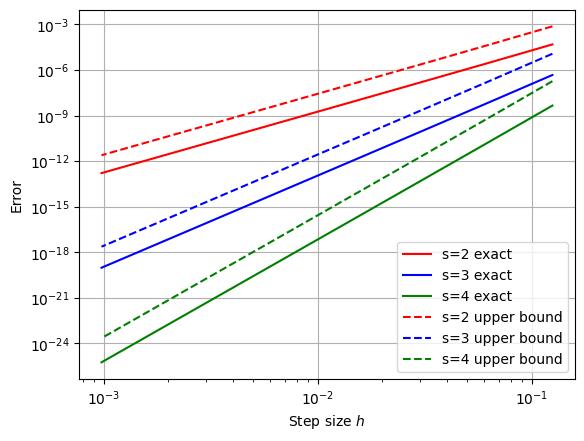

In [20]:
c = 1
def error_exp_Magnus_Taylor_truncation(h, s, c):
    r"""
    Computes the error of the Taylor truncation of the Magnus expansion of order 2s+1.
    h: step size
    s: order of the Magnus expansion
    c: norm of the Hamiltonian and its derivatives
    """

    c = max(c,1)

    return np.e*(h*c)**(2*s+1)/(1-h*c)

# Plot the error of the Taylor truncation for different values of s and h
hs = [1/(2) * 1/2**i for i in range(1,10)]
maxp = 15

for (s, color) in zip([2, 3, 4], ['r', 'b', 'g']):
    plot_hs = []
    step_error = []
    error = []
    for h in hs:
        if h <= 1/(4*m):
            plot_hs.append(h)
        else:
            continue

        bound = []
        for p in range(0, maxp+1):
            bound.append(efficient_bound(h, p, c))
        
        acc_bound = {}
        acc_bound[2*s] = 0
        for i in range(2*s+1, len(bound)):
            acc_bound[i] = acc_bound[i-1] + bound[i]
        error.append(acc_bound[maxp]/h)

    plt.plot(plot_hs, error, color = color, label = f's={s} exact')

for (s, color) in zip([2, 3, 4], ['r', 'b', 'g']):
    plot_hs = []
    upper_bound_error = []
    error_low = []
    for h in hs:
        if h <= 1/(4*m):
            plot_hs.append(h)
        else:
            continue
        upper_bound_error.append(error_exp_Magnus_Taylor_truncation(h, s, c)/h)

    plt.plot(plot_hs, upper_bound_error, color = color, label = f's={s} upper bound', linestyle='dashed')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel(r'Step size $h$')
plt.grid()

Quadrature error

In [21]:
def quadrature_residual(s, m, h, maxc = 1):
    '''
    Computes the error of the quadrature rule for the Magnus expansion of order 2s+1.
    m: number of exponentials in the Commutator Free Magnus operator
    s: 2s is the order of the Magnus expansion
    h: step size
    cs_y: list of the values of the quadrature rule

    n: order of the quadrature rule (2s)
    i: index of the univariate integral
    j: missing terms in the univariate integral, that constitute the error term
    '''
    quadrature_residual = {}
    for i in range(1,m+1):
        quadrature_residual[i-1] = {}
        n = 2*s
        partial_sums = []
        for j in range(0, 350):
            term = math.factorial(2*n+j)/math.factorial(j)*(1-(-1)**(i+j))/((i+j+2*n)*2**(2*n+j+i))* maxc * (h/2)**(j)
            partial_sums.append(term + partial_sums[-1] if len(partial_sums) > 0 else term)

        partial_sums = np.array(partial_sums)
        partial_sums *= (math.factorial(n)/math.factorial(2*n))**3 * math.factorial(n)/(2*n+1) * h**(2*n+1)

        quadrature_residual[i-1] = partial_sums[-1]

    return quadrature_residual

def quadrature_error(s, m, h, cs_y, maxc = 1, qr = None):
    if qr is None:
        qr = quadrature_residual(s, m, h, maxc = maxc)

    error = 0
    for i in range(m):
        for t in range(s):
            error += qr[i] * abs(cs_y[(s,m)][i][t])

    return error

h = 1/10
s = 2
m = 2
qr = quadrature_residual(s, m, h, maxc = 1)
print(qr)

{0: 1.0069697073740207e-17, 1: 9.147225308298062e-19}


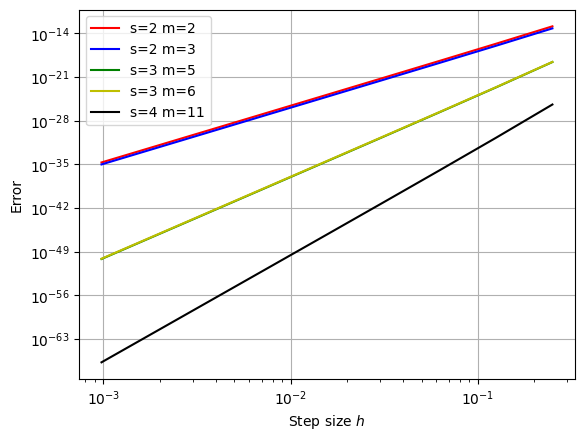

In [22]:
# Plot the error of the quadrature rule for different values of s, m and h
hs = [1/(2) * 1/2**i for i in range(1,10)]
maxp = 15
for (s, m, color) in zip([2,2,3,3,4], [2, 3, 5, 6, 11], ['r', 'b', 'g', 'y', 'k']):
    plot_hs = []
    step_error = []
    error = []
    for h in hs:

        plot_hs.append(h)

        qr = quadrature_residual(s, m, h, maxc = 1)
        qe = quadrature_error(s, m, h, cs_y, maxc = 1, qr = qr)
        error.append(qe)

    plt.plot(plot_hs, error, color = color, label = f's={s} m={m}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel(r'Step size $h$')
plt.grid()
plt.show()


Error from moving from the basis of Lie Algebra generators $\alpha_i$ to the basis of univariate integrals $A^{(i)}$.

In [23]:
def basis_change_error(h, s, m, cs_y, maxc = 1):
    r"""
    Computes the error of the basis change of the Magnus expansion of order 2s+1.
    h: step size
    s: n = 2s is order of the Magnus expansion
    m: number of exponentials in the Commutator Free Magnus operator
    maxc: maximum value of the norm of the Hamiltonian and its derivatives
    cs_y: list of the values of the quadrature rule
    """

    basis_change_error = 0

    for k in range(1, m+1):
        for j in range(s):
            basis_change_error += abs(cs_y[(s,m)][k-1][j])/2**j * (2*maxc)/(2*s+j+1)

    return basis_change_error * (h/2)**(2*s+1) / (1-h/2)


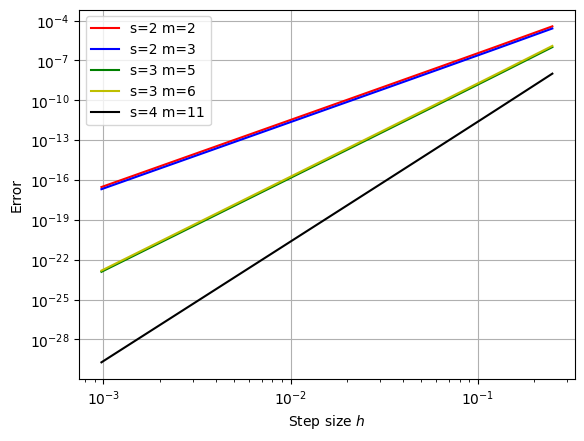

In [25]:
# Plot the error of the quadrature rule for different values of s, m and h
hs = [1/(2) * 1/2**i for i in range(1,10)]
maxp = 15
for (s, m, color) in zip([2,2,3,3,4], [2, 3, 5, 6, 11], ['r', 'b', 'g', 'y', 'k']):
    plot_hs = []
    step_error = []
    error = []
    for h in hs:

        plot_hs.append(h)

        qe = basis_change_error(h, s, m, cs_y, maxc)
        error.append(qe)

    plt.plot(plot_hs, error, color = color, label = f's={s} m={m}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel(r'Step size $h$')
plt.grid()
plt.show()

# Putting all errors together

Now we will plot the joint error for all the different error contributions. We will then analyze the cost in terms of the number of exponentials to be trotterized.

In [43]:
def error_sum(h, s, m, cs_y, maxc = 1, maxp = 25, tight = False):
    error = np.longdouble(0)

    # Error from the Taylor truncation
    error += error_Taylor_truncation(h, s, c)

    # Error from the Taylor expansion of the product of exponentials in the commutator-free operator
    sum_compositions = summatory_compositions(h, maxp, s, [m], [cs[(s,m)]], use_max = not tight or s > 4)
    acc_sum_compositions = acc_from(2*s+1, sum_compositions, maxp)
    error += acc_sum_compositions[maxp]

    # Error from the Taylor expansion of the exponential of the Magnus expansion
    bound_taylor = []
    for p in range(0, maxp+1):
        bound_taylor.append(efficient_bound(h, p, 1))

    acc_bound_taylor = acc_from(2*s+1, bound_taylor, maxp)
    error += acc_bound_taylor[maxp]

    # Error from the quadrature rule
    qr = quadrature_residual(s, m, h, maxc = maxc)
    error += quadrature_error(s, m, h, cs_y, maxc = maxc, qr = qr)

    # Error from the basis change
    error += basis_change_error(h, s, m, cs_y, maxc)
    
    return error


Text(0.5, 0, 'Step size $h$')

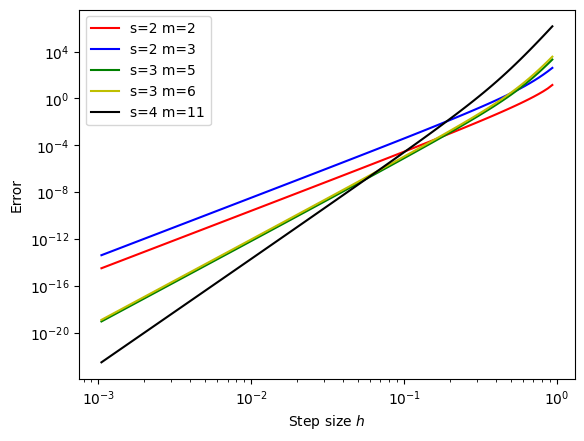

In [69]:
hs = [1/2**(i/10) for i in range(1,100)]
maxp = 15 #todo: change this parameter perhaps
step_error = {}
for (s, m, color) in zip([2,2,3,3,4], [2, 3, 5, 6, 11], ['r', 'b', 'g', 'y', 'k']):
    step_error[(s,m)] = {}
    for h in hs:
        step_error[(s,m)][h] = error_sum(h, s, m, cs_y, maxc = 1, maxp = maxp, tight = False)

    plt.plot(step_error[(s,m)].keys(), step_error[(s,m)].values(), color = color, label = f's={s} m={m}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel(r'Step size $h$')

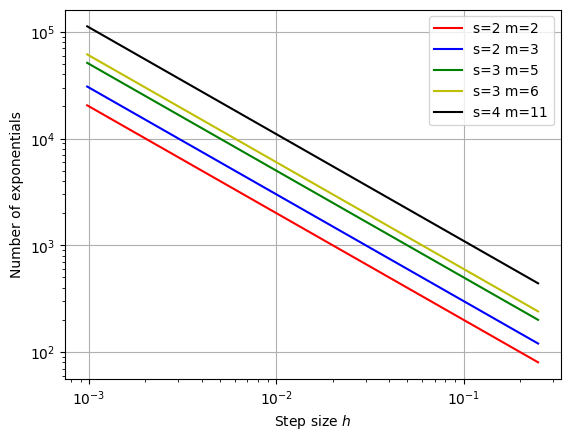

In [ ]:
total_time = 10

for (s, m, color) in zip([2,2,3,3,4], [2, 3, 5, 6, 11], ['r', 'b', 'g', 'y', 'k']):
    plot_hs = []
    cost_exponentials = []
    for h in hs:
        plot_hs.append(h)
        cost_exponentials.append(total_time*m/h)

    plt.plot(plot_hs, cost_exponentials, color = color, label = f's={s} m={m}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel(r'Step size $h$')
plt.ylabel('Number of exponentials')

plt.yscale('log')
plt.xscale('log')
plt.grid()


In [60]:
def minimize_cost(hs, s, m, total_time, total_error):

    cost_exponentials = {}
    errors = {}
    for h in hs:
        cost_exponentials[h] = total_time*m/h
        errors[h] = total_time*step_error[(s,m)][h]/h

    min_cost = np.inf
    for h in hs:
        if errors[h] < total_error and cost_exponentials[h] < min_cost:
            min_cost_h = h
            min_cost = cost_exponentials[h]

    return min_cost_h, min_cost

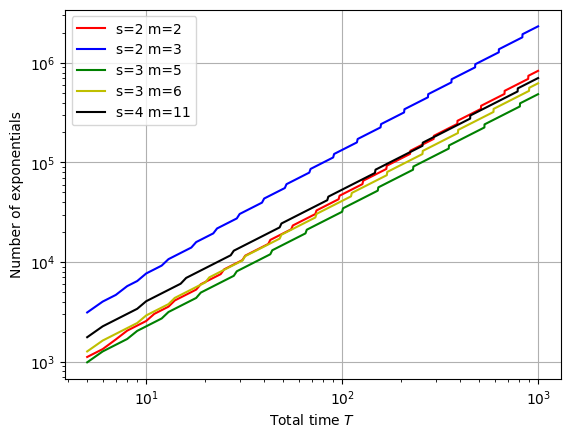

In [73]:
total_error = 1e-7
for (s, m, color) in zip([2,2,3,3,4], [2, 3, 5, 6, 11], ['r', 'b', 'g', 'y', 'k']):
    min_costs = []
    min_costs_h = []
    for total_time in range(5, 1001):
        min_cost_h, min_cost = minimize_cost(hs, s, m, total_time, total_error)
        min_costs.append(min_cost)
        min_costs_h.append(min_cost_h)
    plt.plot(range(5, 1001), min_costs, color = color, label = f's={s} m={m}')

plt.xlabel(r'Total time $T$')
plt.ylabel('Number of exponentials')

plt.yscale('log')
plt.xscale('log')
plt.grid()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


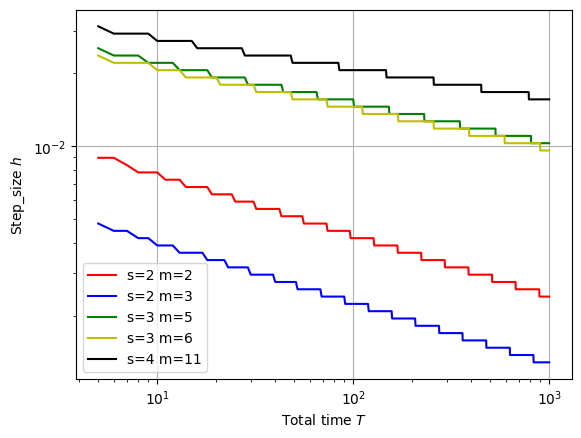

In [75]:
total_error = 1e-7
for (s, m, color) in zip([2,2,3,3,4], [2, 3, 5, 6, 11], ['r', 'b', 'g', 'y', 'k']):
    min_costs = []
    min_costs_h = []
    for total_time in range(5, 1001):
        min_cost_h, min_cost = minimize_cost(hs, s, m, total_time, total_error)
        min_costs.append(min_cost)
        min_costs_h.append(min_cost_h)
    plt.plot(range(5, 1001), min_costs_h, color = color, label = f's={s} m={m}')

plt.xlabel(r'Total time $T$')
plt.ylabel('Step_size $h$')

plt.yscale('log')
plt.xscale('log')
plt.grid()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


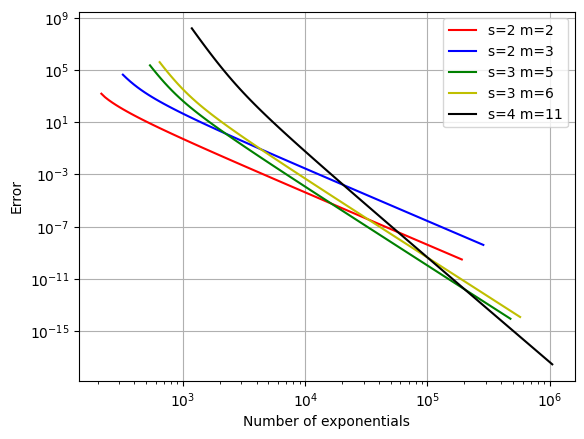

In [76]:
# For a fixed amount of time = 100, plot the error vs the number of exponentials
total_time = 100
for (s, m, color) in zip([2,2,3,3,4], [2, 3, 5, 6, 11], ['r', 'b', 'g', 'y', 'k']):
    errors = {}
    cost_exponentials = {}
    for h in hs:
        cost_exponentials[h] = total_time*m/h
        errors[h] = total_time*step_error[(s,m)][h]/h

    plt.plot(cost_exponentials.values(), errors.values(), color = color, label = f's={s} m={m}')

plt.xlabel(r'Number of exponentials')
plt.ylabel('Error')

plt.yscale('log')
plt.xscale('log')
plt.grid()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()  